In [1]:
from typing import Tuple
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Notebook display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (10, 6)

In [36]:
game_info = pd.read_csv("/kaggle/input/top-1000-steam-games/93182_steam_games.csv").iloc[:, [0, 2, 3, 6, 16, 17, 18, 34]]
print("Dataset shape:", game_info.shape)
game_info['Single-player'] = game_info['Categories'].str.contains('Single-player', na=False).astype(int)
game_info['Multi-player'] = game_info['Categories'].str.contains('Multi-player', na=False).astype(int)
game_info['Windows'] = game_info['Windows'].astype(int)
game_info['Mac'] = game_info['Mac'].astype(int)
game_info['Linux'] = game_info['Linux'].astype(int)
game_info.drop('Categories', axis=1, inplace=True)
game_info.head()

/tmp/ipykernel_38/2070134477.py:1: DtypeWarning: Columns (3,36) have mixed types. Specify dtype option on import or set low_memory=False.
  game_info = pd.read_csv("/kaggle/input/top-1000-steam-games/93182_steam_games.csv").iloc[:, [0, 2, 3, 6, 16, 17, 18, 34]]


Dataset shape: (93182, 8)


,AppID,Release date,Estimated owners,Price,Windows,Mac,Linux,Single-player,Multi-player
0,1424640,"Oct 3, 2020",20000 - 50000,3.99,1,0,0,1,0
1,402890,"Sep 23, 2015",50000 - 100000,0.00,1,0,0,1,0
2,1151740,"Apr 2, 2020",0 - 20000,19.99,1,0,0,1,0
3,875530,"Oct 12, 2018",0 - 20000,7.99,1,0,0,1,0
4,1835360,"Mar 11, 2022",0 - 20000,3.99,1,0,0,1,0


In [37]:
player_info = pd.read_csv("/kaggle/input/steam-releases/game_data_all.csv").iloc[:, [2, 4, 8, 9]]
player_info.iloc[:, 0] = player_info.iloc[:, 0].str.replace(r'^/app/(.*)/$', r'\1', regex=True)
player_info.iloc[:, 0] = player_info.iloc[:, 0].astype(int)
print("Dataset shape:", player_info.shape)
player_info.head()

Dataset shape: (67571, 4)


,link,peak_players,rating,primary_genre
0,2231450,4529,96.39,Action (1)
1,2050650,168191,95.75,Action (1)
2,2324650,15543,95.54,Casual (4)
3,2263010,1415,95.39,Indie (23)
4,1817230,6132,95.09,Action (1)


In [38]:
game_info_last_col = game_info.columns[0]
player_info_third_col = player_info.columns[0]

df = game_info.merge(player_info, left_on=game_info_last_col, right_on=player_info_third_col, how='inner')
df = df.iloc[:, [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12]]
df['Release date'] = pd.to_datetime(df['Release date'], format='mixed')
df['day'] = df['Release date'].dt.day
df['month'] = df['Release date'].dt.month
df['year'] = df['Release date'].dt.year
df.drop('Release date', axis=1,  inplace=True)
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (63123, 13)


,Estimated owners,Price,Windows,Mac,Linux,Single-player,Multi-player,peak_players,rating,primary_genre,day,month,year
0,20000 - 50000,3.99,1,0,0,1,0,4,45.52,Adventure (25),3,10,2020
1,50000 - 100000,0.00,1,0,0,1,0,68,61.39,Indie (23),23,9,2015
2,0 - 20000,19.99,1,0,0,1,0,165,79.84,Adventure (25),2,4,2020
3,0 - 20000,7.99,1,0,0,1,0,3,60.28,Action (1),12,10,2018
4,0 - 20000,3.99,1,0,0,1,0,4,60.54,Indie (23),11,3,2022


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


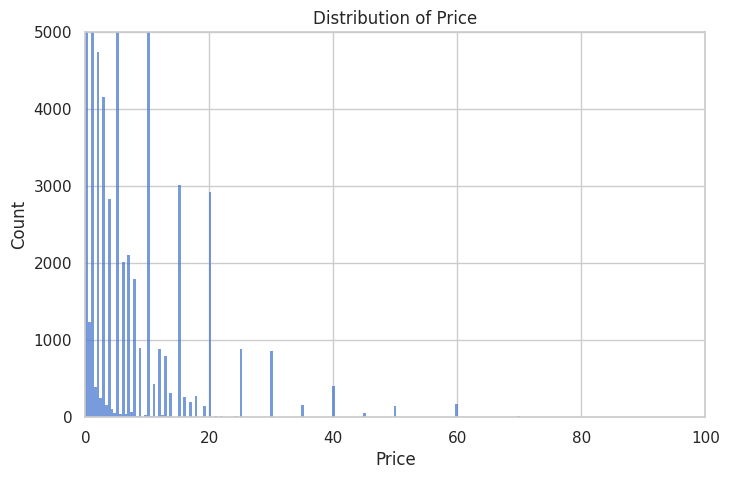

In [5]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Price'])
plt.title(f"Distribution of Price")
plt.xlim(0, 100)
plt.ylim(0, 5000)
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


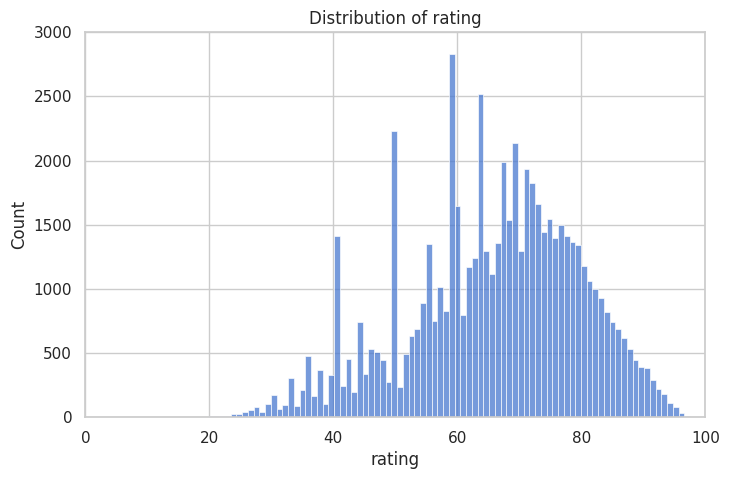

In [6]:
plt.figure(figsize=(8, 5))
sns.histplot(df['rating'])
plt.title(f"Distribution of rating")
plt.xlim(0, 100)
plt.ylim(0, 3000)
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


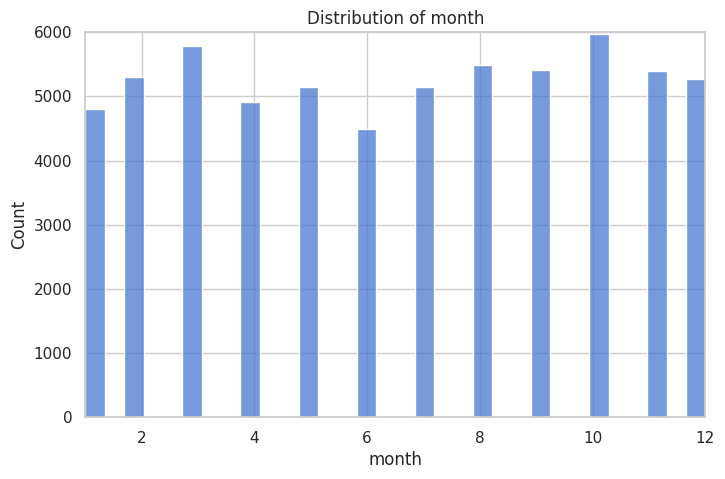

In [7]:
plt.figure(figsize=(8, 5))
sns.histplot(df['month'])
plt.title(f"Distribution of month")
plt.xlim(1, 12)
plt.ylim(0, 6000)
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


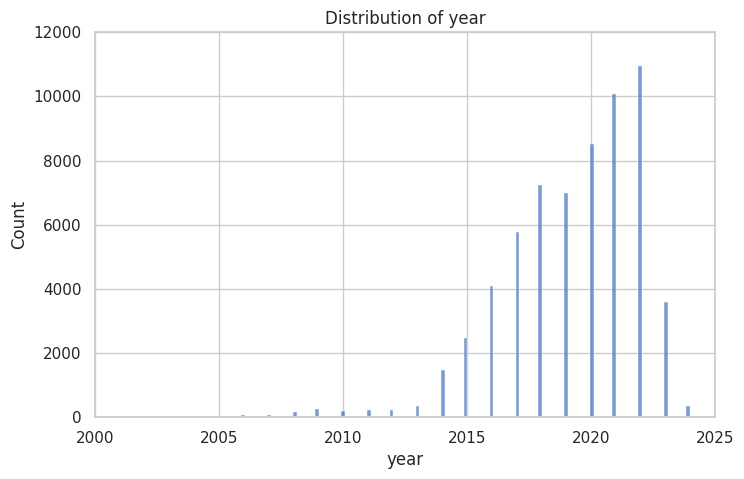

In [8]:
plt.figure(figsize=(8, 5))
sns.histplot(df['year'])
plt.title(f"Distribution of year")
plt.xlim(2000, 2025)
plt.ylim(0, 12000)
plt.show()

,Price,Windows,Mac,Linux,Single-player,Multi-player,peak_players,rating
count,63123.000000,63123.000000,63123.000000,63123.000000,63123.000000,63123.000000,6.312300e+04,63123.000000
mean,7.324526,0.999731,0.219207,0.152718,0.956513,0.197377,9.702194e+02,65.717527
std,12.270882,0.016409,0.413712,0.359718,0.203951,0.398022,2.039624e+04,13.903027
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,15.090000
25%,0.990000,1.000000,0.000000,0.000000,1.000000,0.000000,3.000000e+00,57.390000
50%,4.990000,1.000000,0.000000,0.000000,1.000000,0.000000,7.000000e+00,67.060000
75%,9.990000,1.000000,0.000000,0.000000,1.000000,0.000000,4.500000e+01,75.850000
max,999.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.257248e+06,97.540000


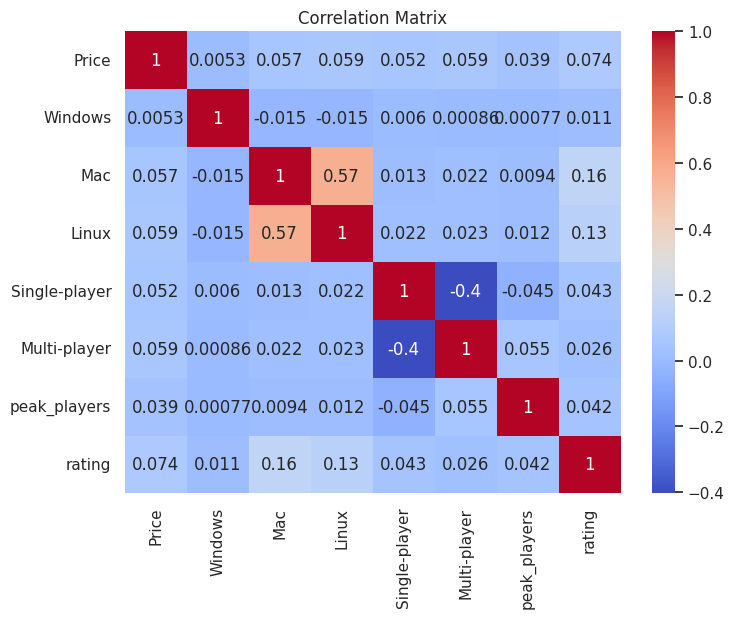


[CV] END colsample_bytree=0.8598531596188859, gamma=8.49223410494178, learning_rate=0.16940322307508585, max_depth=3, n_estimators=787, subsample=0.637469907131237; total time=  27.8s
[CV] END colsample_bytree=0.8598531596188859, gamma=8.49223410494178, learning_rate=0.16940322307508585, max_depth=3, n_estimators=787, subsample=0.637469907131237; total time=  28.2s
[CV] END colsample_bytree=0.9568186220708453, gamma=6.311386259972629, learning_rate=0.2037028258854121, max_depth=3, n_estimators=383, subsample=0.8675696238652398; total time=  13.3s
[CV] END colsample_bytree=0.9456670260287612, gamma=2.3018526824155527, learning_rate=0.12979834497118808, max_depth=6, n_estimators=646, subsample=0.9074216057225236; total time=  23.0s
[CV] END colsample_bytree=0.9456670260287612, gamma=2.3018526824155527, learning_rate=0.12979834497118808, max_depth=6, n_estimators=646, subsample=0.9074216057225236; total time=  22.9s
[CV] END colsample_bytree=0.6174415087017735, gamma=9.94550510797341, le

In [47]:
temp_df = df.iloc[:, 1:9]

display(temp_df.describe())

plt.figure(figsize=(8,6))
sns.heatmap(temp_df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

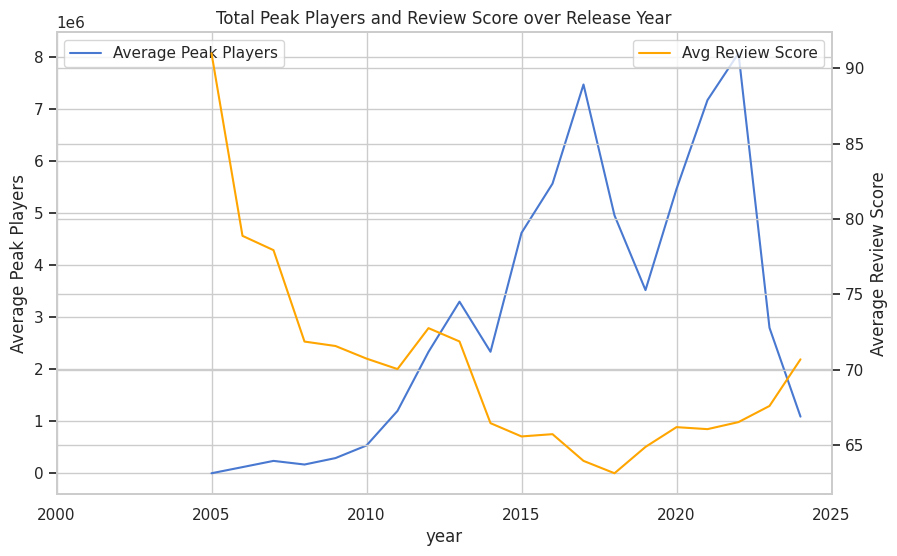

In [10]:
def plot_temporal_trends_by_year(df):
    yearly = df.groupby('year').agg({
        'peak_players': 'sum',
        'rating': 'mean'
    }).reset_index()

    fig, ax1 = plt.subplots()
    sns.lineplot(data=yearly, x='year', y='peak_players', label='Average Peak Players', ax=ax1)
    ax1.set_ylabel("Average Peak Players")
    ax2 = ax1.twinx()
    sns.lineplot(data=yearly, x='year', y='rating', color='orange', label='Avg Review Score', ax=ax2)
    ax2.set_ylabel("Average Review Score")
    plt.title("Total Peak Players and Review Score over Release Year")
    plt.xlim(2000, 2025)
    plt.show()

plot_temporal_trends_by_year(df)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


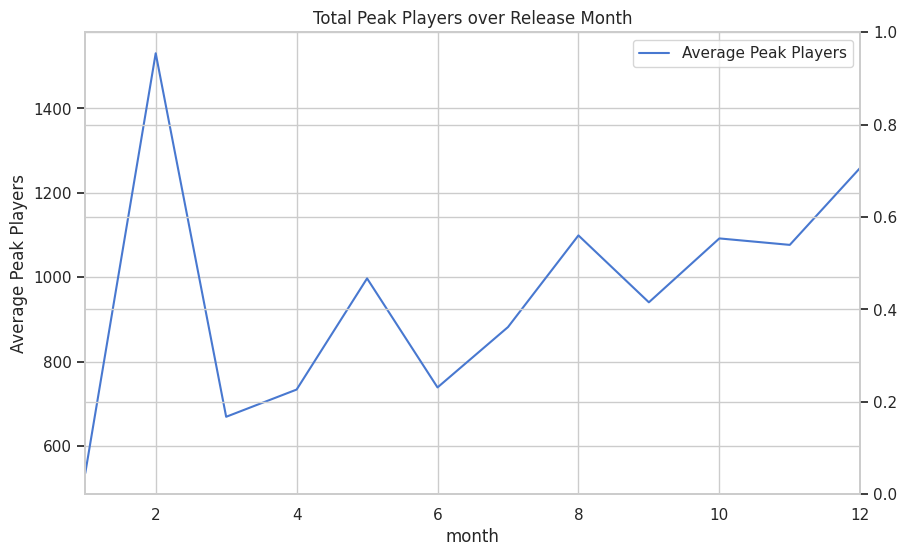

In [11]:
def plot_temporal_trends_by_month(df):
    yearly = df.groupby('month').agg({
        'peak_players': 'mean',
    }).reset_index()

    fig, ax1 = plt.subplots()
    sns.lineplot(data=yearly, x='month', y='peak_players', label='Average Peak Players', ax=ax1)
    ax1.set_ylabel("Average Peak Players")
    ax2 = ax1.twinx()
    plt.title("Total Peak Players over Release Month")
    plt.xlim(1, 12)
    plt.show()

plot_temporal_trends_by_month(df)

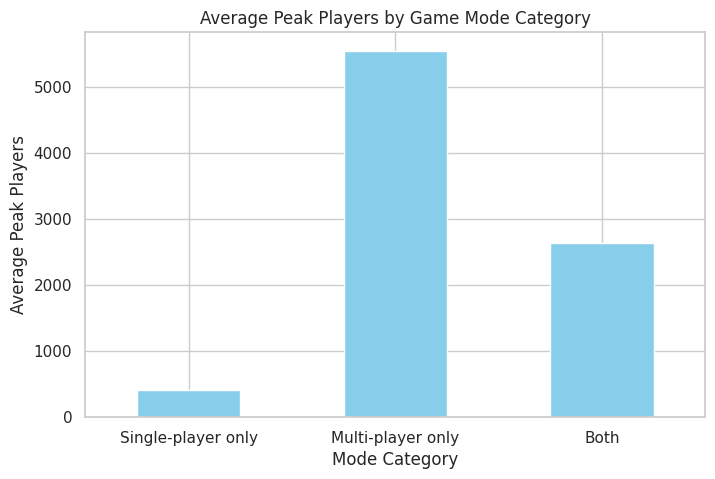

In [39]:
def categorize(row):
    if row['Single-player'] == 1 and row['Multi-player'] == 0:
        return 'Single-player only'
    elif row['Single-player'] == 0 and row['Multi-player'] == 1:
        return 'Multi-player only'
    elif row['Single-player'] == 1 and row['Multi-player'] == 1:
        return 'Both'
    else:
        return 'None'

df['Mode Category'] = df.apply(categorize, axis=1)

# Compute average peak players per category
avg_peak = df.groupby('Mode Category')['peak_players'].mean().reindex(['Single-player only', 'Multi-player only', 'Both'])

# Plot as column chart
plt.figure(figsize=(8,5))
avg_peak.plot(kind='bar', color='skyblue')
plt.ylabel('Average Peak Players')
plt.title('Average Peak Players by Game Mode Category')
plt.xticks(rotation=0)
plt.show()

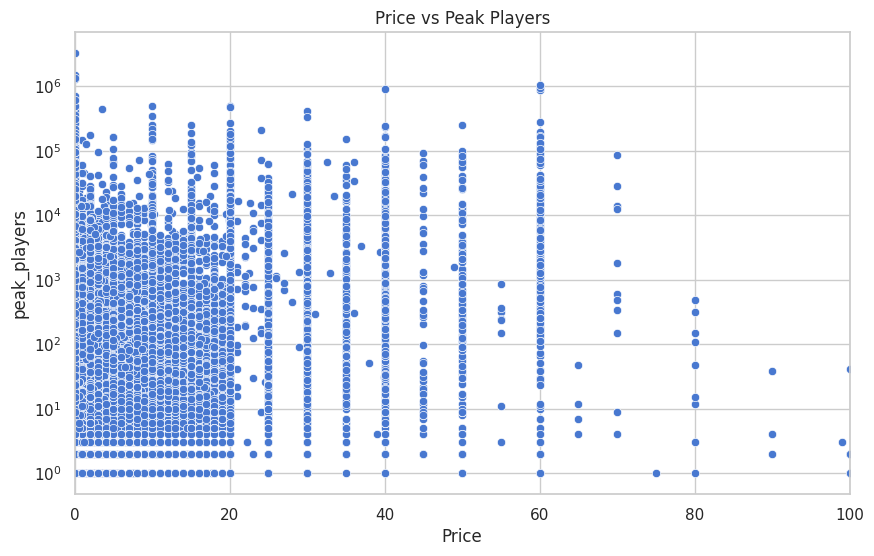

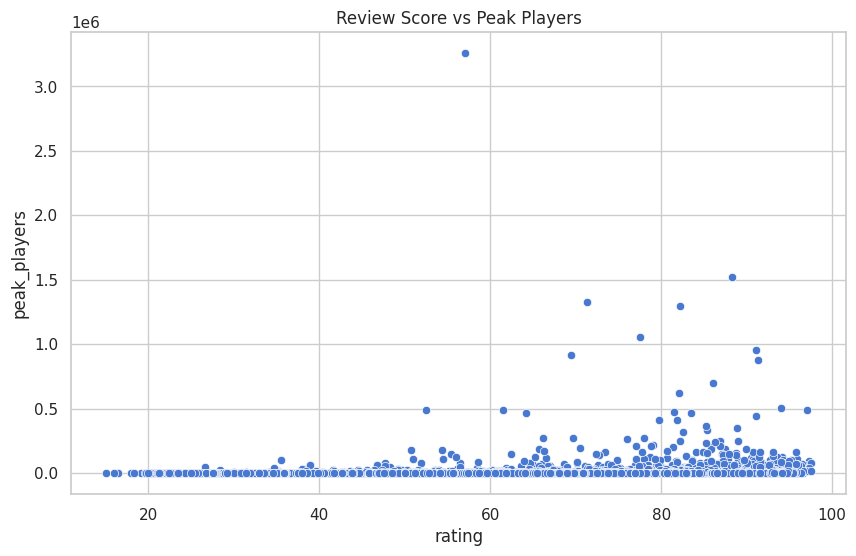

In [13]:
def plot_relationships(df):
    # Price vs Copies Sold
    sns.scatterplot(data=df, x='Price', y='peak_players')
    plt.xlim(0, 100)
    plt.yscale('log')
    plt.title("Price vs Peak Players")
    plt.show()

    # Review Score vs Revenue
    sns.scatterplot(data=df, x='rating', y='peak_players')
    plt.title("Review Score vs Peak Players")
    plt.show()

plot_relationships(df)

In [40]:
from sklearn.preprocessing import OneHotEncoder

X = df[['primary_genre', 'Mode Category']]

encoder = OneHotEncoder(drop=None, sparse_output=False)

X_encoded = encoder.fit_transform(X)

df_encoded_skl = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(
    ['primary_genre', 'Mode Category']
))

df = pd.concat(
    [df.drop(['primary_genre', 'Mode Category'], axis=1), df_encoded_skl], 
    axis=1
)

df.head()

,Estimated owners,Price,Windows,Mac,Linux,Single-player,Multi-player,peak_players,rating,day,month,year,primary_genre_Action (1),primary_genre_Adventure (25),primary_genre_Casual (4),primary_genre_Design & Illustration (53),primary_genre_Early Access (70),primary_genre_Education (54),primary_genre_Free to Play (37),primary_genre_Game Development (60),primary_genre_Gore (74),primary_genre_Indie (23),primary_genre_Massively Multiplayer (29),primary_genre_Nudity (72),primary_genre_RPG (3),primary_genre_Racing (9),primary_genre_Sexual Content (71),primary_genre_Simulation (28),primary_genre_Sports (18),primary_genre_Strategy (2),primary_genre_Unknown Genre (0),primary_genre_Unknown Genre (21),primary_genre_Unknown Genre (33),primary_genre_Unknown Genre (34),primary_genre_Unknown Genre (6),primary_genre_Utilities (57),primary_genre_Video Production (58),primary_genre_Violent (73),primary_genre_Web Publishing (59),primary_genre_nan,Mode Category_Both,Mode Category_Multi-player only,Mode Category_None,Mode Category_Single-player only
0,20000 - 50000,3.99,1,0,0,1,0,4,45.52,3,10,2020,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,50000 - 100000,0.00,1,0,0,1,0,68,61.39,23,9,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0 - 20000,19.99,1,0,0,1,0,165,79.84,2,4,2020,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0 - 20000,7.99,1,0,0,1,0,3,60.28,12,10,2018,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0 - 20000,3.99,1,0,0,1,0,4,60.54,11,3,2022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [42]:
from sklearn.model_selection import train_test_split

new_bins = [
    -np.inf, 
    100,
    1000,  
    5000,
    25000,    
    np.inf        
]

new_labels = [
    '0 - 100', 
    '101 - 1K',
    '1K - 5K', 
    '5K - 25K',
    '25K+'        
]

df['merged_tier_label'] = pd.cut(
    df['peak_players'], 
    bins=new_bins, 
    labels=new_labels, 
    right=True, 
    include_lowest=True
)

df['merged_tier_class'], player_tier_mapping = pd.factorize(df['merged_tier_label'], sort=True)

int_to_label_merged = dict(enumerate(new_labels))
num_classes_merged = len(new_labels)

print("Merged Player Tier Mapping (Class ID: Tier Label):")
print(int_to_label_merged)

Merged Player Tier Mapping (Class ID: Tier Label):
{0: '0 - 100', 1: '101 - 1K', 2: '1K - 5K', 3: '5K - 25K', 4: '25K+'}


In [43]:
print("--- Total Count of Samples in Each Player Tier (Full Dataset) ---")
bin_counts_full = df['merged_tier_class'].value_counts().sort_index() 
print(bin_counts_full)
print(f"\nTotal Samples: {bin_counts_full.sum()}")

--- Total Count of Samples in Each Player Tier (Full Dataset) ---
merged_tier_class
0    51096
1     7883
2     2929
3      876
4      339
Name: count, dtype: int64

Total Samples: 63123


In [44]:
X = df.drop([
    'peak_players', 'log_peak_players', 'Estimated owners', 
    'owner_class', 'player_tier_label', 'player_tier_class',
    'merged_tier_label',
    'merged_tier_class'
], axis=1, errors='ignore')

y = df['merged_tier_class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [45]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import f1_score, make_scorer
import xgboost as xgb

xgb_base = xgb.XGBClassifier(
    objective='multi:softmax', 
    num_class=len(y.unique()), 
    use_label_encoder=False,
    eval_metric='merror',
    random_state=42,
    n_jobs=-1
)

param_dist = {
    'n_estimators': randint(100, 1500),  
    'max_depth': randint(3, 15),   
    'learning_rate': uniform(0.005, 0.25), 
    'subsample': uniform(0.6, 0.4),      
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 10)  
}

macro_f1_scorer = make_scorer(f1_score, average='macro')

In [46]:
random_search = RandomizedSearchCV(
    estimator=xgb_base, 
    param_distributions=param_dist, 
    n_iter=75,               
    scoring=macro_f1_scorer, 
    cv=5,             
    verbose=2,
    random_state=42,
    n_jobs=-1
)

print("Starting Randomized Search for Optimal Hyperparameters...")
random_search.fit(X_train, y_train, sample_weight=sample_weights)
print("Tuning complete.")

Starting Randomized Search for Optimal Hyperparameters...
Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV] END colsample_bytree=0.749816047538945, gamma=9.50714306409916, learning_rate=0.18799848545285128, max_depth=7, n_estimators=221, subsample=0.662397808134481; total time=   9.1s
[CV] END colsample_bytree=0.6232334448672797, gamma=8.661761457749352, learning_rate=0.1552787529358022, max_depth=10, n_estimators=230, subsample=0.608233797718321; total time=   9.1s
[CV] END colsample_bytree=0.9879639408647978, gamma=8.324426408004218, learning_rate=0.058084777669569036, max_depth=14, n_estimators=376, subsample=0.8469926038510867; total time=  15.1s
[CV] END colsample_bytree=0.8446612641953124, gamma=0.07066305219717406, learning_rate=0.01076560626035394, max_depth=13, n_estimators=1182, subsample=0.7599443886861021; total time= 2.5min


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=0.749816047538945, gamma=9.50714306409916, learning_rate=0.18799848545285128, max_depth=7, n_estimators=221, subsample=0.662397808134481; total time=   8.6s
[CV] END colsample_bytree=0.749816047538945, gamma=9.50714306409916, learning_rate=0.18799848545285128, max_depth=7, n_estimators=221, subsample=0.662397808134481; total time=   8.4s
[CV] END colsample_bytree=0.6232334448672797, gamma=8.661761457749352, learning_rate=0.1552787529358022, max_depth=10, n_estimators=230, subsample=0.608233797718321; total time=   9.2s
[CV] END colsample_bytree=0.9879639408647978, gamma=8.324426408004218, learning_rate=0.058084777669569036, max_depth=14, n_estimators=376, subsample=0.8469926038510867; total time=  15.0s
[CV] END colsample_bytree=0.8446612641953124, gamma=0.07066305219717406, learning_rate=0.01076560626035394, max_depth=13, n_estimators=1182, subsample=0.7599443886861021; total time= 2.5min
[CV] END colsample_bytree=0.749816047538945, gamma=9.50714306409916, le

In [48]:
from sklearn.metrics import accuracy_score, classification_report

best_xgb = random_search.best_estimator_

print("\n--- Best Model Parameters ---")
print(random_search.best_params_)

y_pred_tuned = best_xgb.predict(X_test)

accuracy_tuned = accuracy_score(y_test, y_pred_tuned)

print("\n--- Tuned XGBoost Final Performance ---")
print(f"Overall Classification Accuracy (Tuned): {accuracy_tuned:.4f}")

target_names = ['0 - 100', '101 - 1K', '1K - 5K', '5K - 25K', '25K+']
print("\nClassification Report (Tuned):")
print(classification_report(y_test, y_pred_tuned, target_names=target_names))


--- Best Model Parameters ---
{'colsample_bytree': 0.9687496940092467, 'gamma': 0.884925020519195, 'learning_rate': 0.0539957156047863, 'max_depth': 11, 'n_estimators': 395, 'subsample': 0.9378135394712606}

--- Tuned XGBoost Final Performance ---
Overall Classification Accuracy (Tuned): 0.7368

Classification Report (Tuned):
              precision    recall  f1-score   support

     0 - 100       0.94      0.80      0.87     10219
    101 - 1K       0.32      0.55      0.40      1577
     1K - 5K       0.21      0.32      0.25       586
    5K - 25K       0.19      0.21      0.20       175
        25K+       0.16      0.19      0.18        68

    accuracy                           0.74     12625
   macro avg       0.36      0.41      0.38     12625
weighted avg       0.81      0.74      0.77     12625


[CV] END colsample_bytree=0.6377771843023713, gamma=6.830067734163569, learning_rate=0.022797162115057248, max_depth=10, n_estimators=704, subsample=0.9379501243877818; total time= 

In [30]:
import pickle
import time

timestamp = time.strftime("%Y%m%d_%H%M%S")
filename = f'xgb_peak_player_classifier_{timestamp}.pkl'

try:
    with open(filename, 'wb') as file:
        pickle.dump(best_xgb, file)
    print(f"\n✅ Successfully saved the final model to: {filename}")
except Exception as e:
    print(f"\n❌ Error saving the model: {e}")


✅ Successfully saved the final model to: xgb_peak_player_classifier_20251210_192624.pkl



--- Top 15 Feature Importances ---
Mode Category_Single-player only            0.181504
Multi-player                                0.087023
Price                                       0.049748
year                                        0.040440
rating                                      0.039488
primary_genre_Massively Multiplayer (29)    0.035635
primary_genre_Unknown Genre (0)             0.035200
primary_genre_Free to Play (37)             0.031721
Mode Category_Multi-player only             0.029979
primary_genre_Strategy (2)                  0.028890
primary_genre_Indie (23)                    0.028828
Single-player                               0.028543
month                                       0.027630
Linux                                       0.026950
day                                         0.026914
dtype: float32


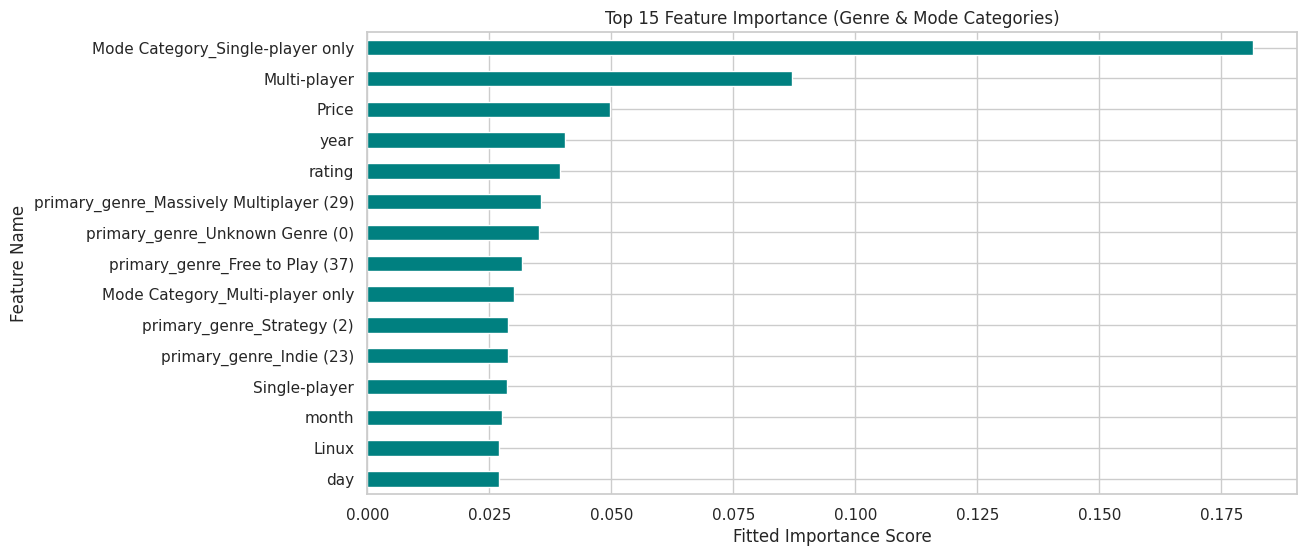

In [49]:
feature_importances = pd.Series(
    best_xgb.feature_importances_, 
    index=X.columns
).sort_values(ascending=False)

print("\n--- Top 15 Feature Importances ---")
print(feature_importances.head(15))

plt.figure(figsize=(12, 6))
feature_importances.head(15).plot(kind='barh', color='teal')
plt.title('Top 15 Feature Importance (Genre & Mode Categories)')
plt.gca().invert_yaxis() # Highest importance at the top
plt.xlabel('Fitted Importance Score')
plt.ylabel('Feature Name')
plt.show()